# Bayesian Inference in Visual-SB1 Systems
### Information and Decision Systems Group<br>University of Chile

Example of Bayesian inference in visual-SB1 systems incorporating a Gaussian prior on the parallax $\pi$ parameter.

In [1]:
import os
import sys
import logging
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython.utils import io
from tqdm.notebook import tqdm
from cmdstanpy import CmdStanModel
sys.path.append( '../src' )
from utils import update_namespace, read_in3, getOrbit, getRVSingle

## 1. Observations

In [2]:
system = 'HIP109951'

### 1.1. Data Parsing

In [3]:
df_as, df_v1, df_v2, df_priors = read_in3('./data/{}.in3'.format(system))
print('Astrometric observations:')
display(df_as)
print('V1 observations:')
display(df_v1)
print('Priors:')
display(df_priors)

Astrometric observations:


,epoch,X,Y,X_err,Y_err
0,1991.2500,0.160381,-0.081718,0.010,0.010
1,1999.8152,0.099174,0.280059,0.005,0.005
2,2000.7672,0.087761,0.296275,0.005,0.005
3,2000.8726,0.075238,0.301762,0.005,0.005
4,2003.6368,0.015605,0.343646,0.005,0.005
5,2004.8152,-0.015572,0.356660,0.005,0.005
6,2006.5173,-0.055926,0.369795,0.005,0.005
7,2006.5174,-0.049039,0.362700,0.005,0.005
8,2007.8171,-0.090709,0.372103,0.005,0.005
9,2007.8199,-0.093929,0.379550,0.005,0.005


V1 observations:


,epoch,RV,err
0,1987.527,-20.42,0.34
1,1988.480,-20.41,0.68
2,1988.592,-21.87,0.84
3,1989.460,-21.39,0.49
4,1990.533,-23.11,0.88
5,1990.686,-21.12,0.72
6,1992.603,-24.55,0.81
7,1992.671,-23.40,0.59
8,1992.720,-22.40,0.65
9,1992.786,-21.76,0.58


Priors:


,param,mean,std
0,plx,0.01511764157,0.00053421
1,m1,0.95499258602,0.0146648601


### 1.2. Data Visualization

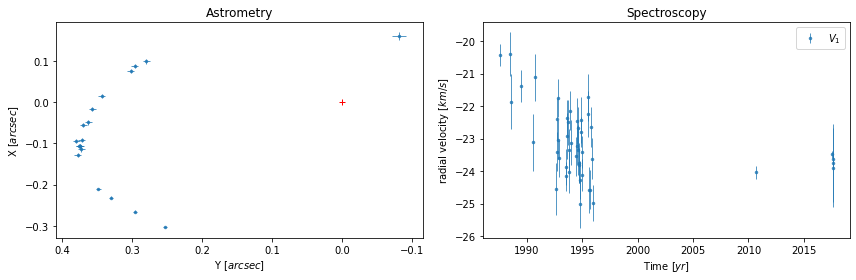

In [4]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.errorbar(df_as.Y, df_as.X, xerr=df_as.Y_err, yerr=df_as.X_err, fmt='.', elinewidth=1, ms=5, alpha=0.75)
plt.plot([0],[0],'+',color='r')
plt.xlabel(r'Y $[arcsec]$')
plt.ylabel(r'X $[arcsec]$')
plt.gca().invert_xaxis()
plt.title('Astrometry')
plt.subplot(1,2,2)
plt.errorbar(df_v1.epoch, df_v1.RV, yerr=df_v1.err, label=r'$V_1$', fmt='.', elinewidth=1, ms=5, alpha=0.75)
plt.ylabel(r'radial velocity [$km/s$]')
plt.xlabel('Time [$yr$]')
plt.title('Spectroscopy')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Bayesian Inference

### 2.1. Statistical Model

In [5]:
# Model paths
stan_file = '../src/visual_sb1_priors.stan'
user_header = '../src/kepler_eq.hpp'

In [6]:
# Model compilation
update_namespace(user_header, os.path.basename(stan_file).replace('.stan', ''))
model = CmdStanModel(stan_file=stan_file, user_header=user_header)
print(model.code())

INFO:cmdstanpy:found newer exe file, not recompiling


functions {
    real kepler_eq(real M, real e);
    vector[] orbit(int N, vector t, real T, real P, real e, real a, real w, real Omega, real i) {
        // Variables declaration
        real M; real A; real B; real F; real G;
        vector[N] E; vector[N] x; vector[N] y; vector[N] pos[2];
        // Iterate over epochs
        for (j in 1:N) {
            // Mean anomaly
            M = 2 * pi() * (t[j] - T) / P;
            // Eccentric anomaly
            E[j] = kepler_eq(M, e);
        }
        // Auxiliary normalized coordinates
        x = cos(E) - e;
        y = sin(E) * sqrt(1 - e^2);
        // Thiele-Innes constants
        A = a * (cos(w) * cos(Omega) - sin(w) * sin(Omega) * cos(i));
        B = a * (cos(w) * sin(Omega) + sin(w) * cos(Omega) * cos(i));
        F = a * (-sin(w) * cos(Omega) - cos(w) * sin(Omega) * cos(i));
        G = a * (-sin(w) * sin(Omega) + cos(w) * cos(Omega) * cos(i));
        // Apparent orbit
        pos[1] = A * x + F * y;
        pos[2] = B * x +

#### 2.1.1. Incoporating priors
*  Any prior on the model's parameters from the `parameters` or `transformed_parameters` blocks of the `.stan` file can be incorporated by modifing the `model` block. In this example we incorporate a normal prior on the parameter `plx` and the transformed parameter `m1`. 
*  The prior parameters can be incorporated as an additional input by modifying the `data` block or as a fixed value in the `model` block. In this example we incorporate the data variables `plx_obs`, `plx_err` for the mean and std of the `normal` prior distribution (the same for the parameter `m1`).
*  See the [Stan manual](https://mc-stan.org/docs/2_28/functions-reference/index.html) for details about the available probability distributions.

In [7]:
# Orbital data dictionary
# The keys and values must match the variables of the `data` block shown in model.code()
data = dict(N_as=len(df_as), 
            N_v1=len(df_v1),
            t_as=df_as.epoch.tolist(),
            t_v1=df_v1.epoch.tolist(),
            x_obs=df_as.X.tolist(),
            y_obs=df_as.Y.tolist(),
            x_err=df_as.X_err.tolist(),
            y_err=df_as.Y_err.tolist(),
            v1_obs=df_v1.RV.tolist(),
            v1_err=df_v1.err.tolist(),
            plx_obs=float(df_priors[df_priors['param']=='plx']['mean']), # Here we only impose a prior
            plx_err=float(df_priors[df_priors['param']=='plx']['std']),  # on plx, not on m1.
            m1_obs=0,   # m1_obs=0 dismisses the prior on m1.
            m1_err=0)

### 2.2. Optimization Stage

In [8]:
# Initial points dictionary
# The keys and values must match the variables of the `parameters` block shown in model.code() 
V_mean = np.array(df_v1.RV.tolist() + df_v2.RV.tolist()).mean()
def init_func():
    return dict(T0=np.random.uniform(0, 1), 
                log_P=np.log(52), # Providing a previous estimate of P is highly recommended 
                                  # (e.g., from sb9 or orb6 catalogues).
                e=np.random.uniform(0, 1), 
                a=np.random.uniform(0, 1),
                w=np.random.uniform(0, 2*np.pi),
                Omega=np.random.uniform(0, 2*np.pi),
                i=np.random.uniform(0, np.pi),
                V0=np.random.uniform(V_mean-10, V_mean+10),
                plx=np.random.uniform(0, 10),
                q=np.random.uniform(0, 1))

In [9]:
# Maximum likelihood estimation
best_mle = dict(lp__=-np.inf)
logging.getLogger().setLevel(logging.FATAL)
for _ in tqdm(range(1000)):
    mle = model.optimize(data=data, inits=init_func(), require_converged=False).optimized_params_dict
    if mle['lp__'] > best_mle['lp__']:
        best_mle = mle
        print("Current maximum log-probability: {0:.4f}".format(best_mle['lp__']))
logging.getLogger().setLevel(logging.INFO)
best_mle

  0%|          | 0/1000 [00:00<?, ?it/s]

Current maximum log-probability: -73233.4000
Current maximum log-probability: -73233.3000
Current maximum log-probability: -96.5098
Current maximum log-probability: -86.2568
Current maximum log-probability: -49.6928


OrderedDict([('lp__', -49.6928),
             ('T0', 0.0474264),
             ('log_P', 4.01563),
             ('e', 0.404291),
             ('a', 0.307423),
             ('w', 0.976298),
             ('Omega', 4.57301),
             ('i', 0.478566),
             ('V0', -22.925),
             ('f_plx', 21.6613),
             ('q', 0.486896),
             ('P', 55.4582),
             ('plx', 0.0151172),
             ('m1', 1.83901),
             ('w_deg', 55.9378),
             ('Omega_deg', 262.014),
             ('i_deg', 27.4198),
             ('T', 1990.16),
             ('m2', 0.895405),
             ('plx_mas', 15.1172)])

### 2.3. Inference Stage

In [10]:
# MCMC Sampling
fit = model.sample(data=data, iter_warmup=2500, iter_sampling=2500, inits=best_mle, sig_figs=8)
fit.summary()

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-60.000,0.041000,2.30000,-64.000,-60.000,-57.000,3100.0,36.0,1.0
T0,0.047,0.000100,0.00460,0.040,0.047,0.055,2100.0,24.0,1.0
log_P,4.000,0.001900,0.06000,3.900,4.000,4.100,1000.0,12.0,1.0
e,0.410,0.000580,0.02000,0.380,0.420,0.440,1200.0,14.0,1.0
a,0.300,0.000500,0.01600,0.290,0.300,0.330,990.0,11.0,1.0
w,0.950,0.003900,0.13000,0.780,0.920,1.200,1100.0,13.0,1.0
Omega,4.600,0.000730,0.04500,4.500,4.600,4.600,3800.0,44.0,1.0
i,0.430,0.003000,0.10000,0.290,0.420,0.610,1100.0,13.0,1.0
V0,-23.000,0.002800,0.11000,-23.000,-23.000,-23.000,1600.0,18.0,1.0


## 3. Results

### 3.1. Variables Selection

In [11]:
df = fit.draws_pd()[['P', 'T', 'e', 'a', 'w_deg', 'Omega_deg', 'i_deg', 'V0', 'plx_mas', 'f_plx', 'm1', 'q', 
                     'lp__']]
df.columns = [r'$P$ $[yr]$', r'$T$ $[yr]$', r'$e$', r'$a$ $[″]$', r'$\omega$ $[°]$',r'$\Omega$ $[°]$',
              r'$i$ $[°]$', r'$V_{0}$ $[km/s]$', r'$\pi$ $[mas]$', r'$f/\pi$ $[pc]$', r'$m_1$ $[M_\odot]$', 
              r'$q$', 'lp__']
df

,$P$ $[yr]$,$T$ $[yr]$,$e$,$a$ $[″]$,$\omega$ $[°]$,$\Omega$ $[°]$,$i$ $[°]$,$V_{0}$ $[km/s]$,$\pi$ $[mas]$,$f/\pi$ $[pc]$,$m_1$ $[M_\odot]$,$q$,lp__
0,56.750664,1990.1587,0.387219,0.312293,55.798132,264.96411,29.049559,-22.909637,15.085798,18.603393,1.981438,0.390138,-58.138081
1,59.577489,1990.6174,0.386707,0.325693,63.849377,262.59471,32.720704,-22.740495,14.754428,18.543352,2.201260,0.376645,-59.221808
2,59.908564,1990.6821,0.379312,0.327477,64.261892,263.17157,33.302000,-22.847844,15.245282,19.090078,1.957876,0.410504,-58.473504
3,59.945559,1990.6595,0.380598,0.327587,64.339159,263.07970,33.300244,-22.847659,14.179286,19.274765,2.493770,0.376088,-58.534516
4,59.076143,1990.5345,0.385140,0.323873,63.086394,262.40282,32.340826,-22.869908,14.849331,20.782977,2.055410,0.446369,-57.097054
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,50.530582,1989.9968,0.446288,0.286062,48.185822,259.47909,15.932733,-23.109927,14.138646,32.740187,1.742215,0.861857,-60.105577
9996,50.993852,1989.9901,0.443607,0.285280,48.594713,259.85985,15.386427,-23.023669,14.733934,33.863921,1.398628,0.995804,-61.456445
9997,51.750357,1989.7955,0.434378,0.288830,46.221223,263.04613,18.048794,-22.958606,14.888771,33.561147,1.363850,0.998738,-62.382709
9998,51.453983,1989.6506,0.430909,0.286640,44.753067,263.38680,15.601411,-23.100949,15.510901,32.122073,1.196070,0.992994,-61.998576


### 3.2. Point Estimates

In [12]:
# Samples
samples = df.drop(columns=['lp__']).to_numpy()
# MAP sample
map_sample = samples[df[['lp__']].to_numpy().argmax()]
# Uncertainty quantification
#lb = np.quantile(samples, 0.25, axis=0) # Quartile 1
#ub = np.quantile(samples, 0.75, axis=0) # Quartile 3
lb = az.hdi(samples, 0.95)[:,0] # 95% HPDI lower bound
ub = az.hdi(samples, 0.95)[:,1] # 95% HPDI upper bound

/tmp/ipykernel_9069/4117480441.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  lb = az.hdi(samples, 0.95)[:,0] # 95% HPDI lower bound
/tmp/ipykernel_9069/4117480441.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ub = az.hdi(samples, 0.95)[:,1] # 95% HPDI upper bound


In [13]:
# Estimates summary table
summary_table = [[df.columns[i], 
                  r'${:.3f}_{{{:.3f}}}^{{{:.3f}}}$'.format(map_sample[i], lb[i], ub[i])] for i in range(len(map_sample))]
df_summary = pd.DataFrame(summary_table, columns=['Parameter', 'Estimate'])
df_summary

,Parameter,Estimate
0,$P$ $[yr]$,$56.456_{49.910}^{61.601}$
1,$T$ $[yr]$,$1990.269_{1989.488}^{1990.898}$
2,$e$,$0.398_{0.372}^{0.447}$
3,$a$ $[″]$,$0.313_{0.283}^{0.336}$
4,$\omega$ $[°]$,$58.152_{41.999}^{70.100}$
5,$\Omega$ $[°]$,$262.124_{256.999}^{267.043}$
6,$i$ $[°]$,$29.206_{14.844}^{35.782}$
7,$V_{0}$ $[km/s]$,$-22.893_{-23.157}^{-22.725}$
8,$\pi$ $[mas]$,$15.051_{14.072}^{16.188}$
9,$f/\pi$ $[pc]$,$20.963_{17.033}^{32.675}$


## 4. Visualization

### 4.1. Marginal Posterior Distributions

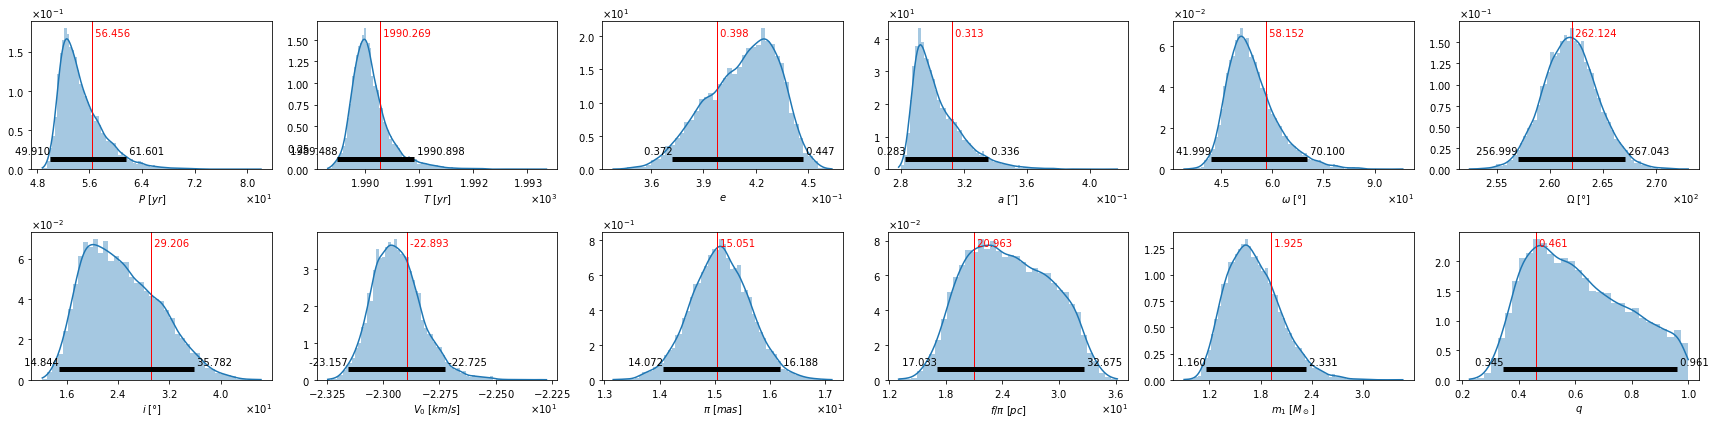

In [14]:
params_names = df.drop(columns=['lp__']).columns.tolist()
plt.figure(figsize=(24,6))
for i in range(samples.shape[1]):
    plt.subplot(2,6,i+1)
    sns.histplot(samples[:,i], stat='density', kde=True, color='tab:blue', alpha=0.4, **{"edgecolor": None})
    min_ylim, max_ylim = plt.ylim()
    plt.axvline(map_sample[i], color='red', linewidth=1)
    plt.text(map_sample[i], max_ylim * 0.9, ' {:.3f}'.format(map_sample[i]), color='red')
    plt.hlines(y=max_ylim * 0.07, xmin=lb[i], xmax=ub[i], linewidth=5, color='black')
    plt.text(lb[i], max_ylim * 0.1, ' {:.3f}'.format(lb[i]), color='black', horizontalalignment='right') 
    plt.text(ub[i], max_ylim * 0.1, ' {:.3f}'.format(ub[i]), color='black') 
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0), useMathText=True)
    plt.xlabel(params_names[i])
    plt.ylabel(None) 
plt.tight_layout()
plt.show()

### 4.2. Pair Posterior Distributions

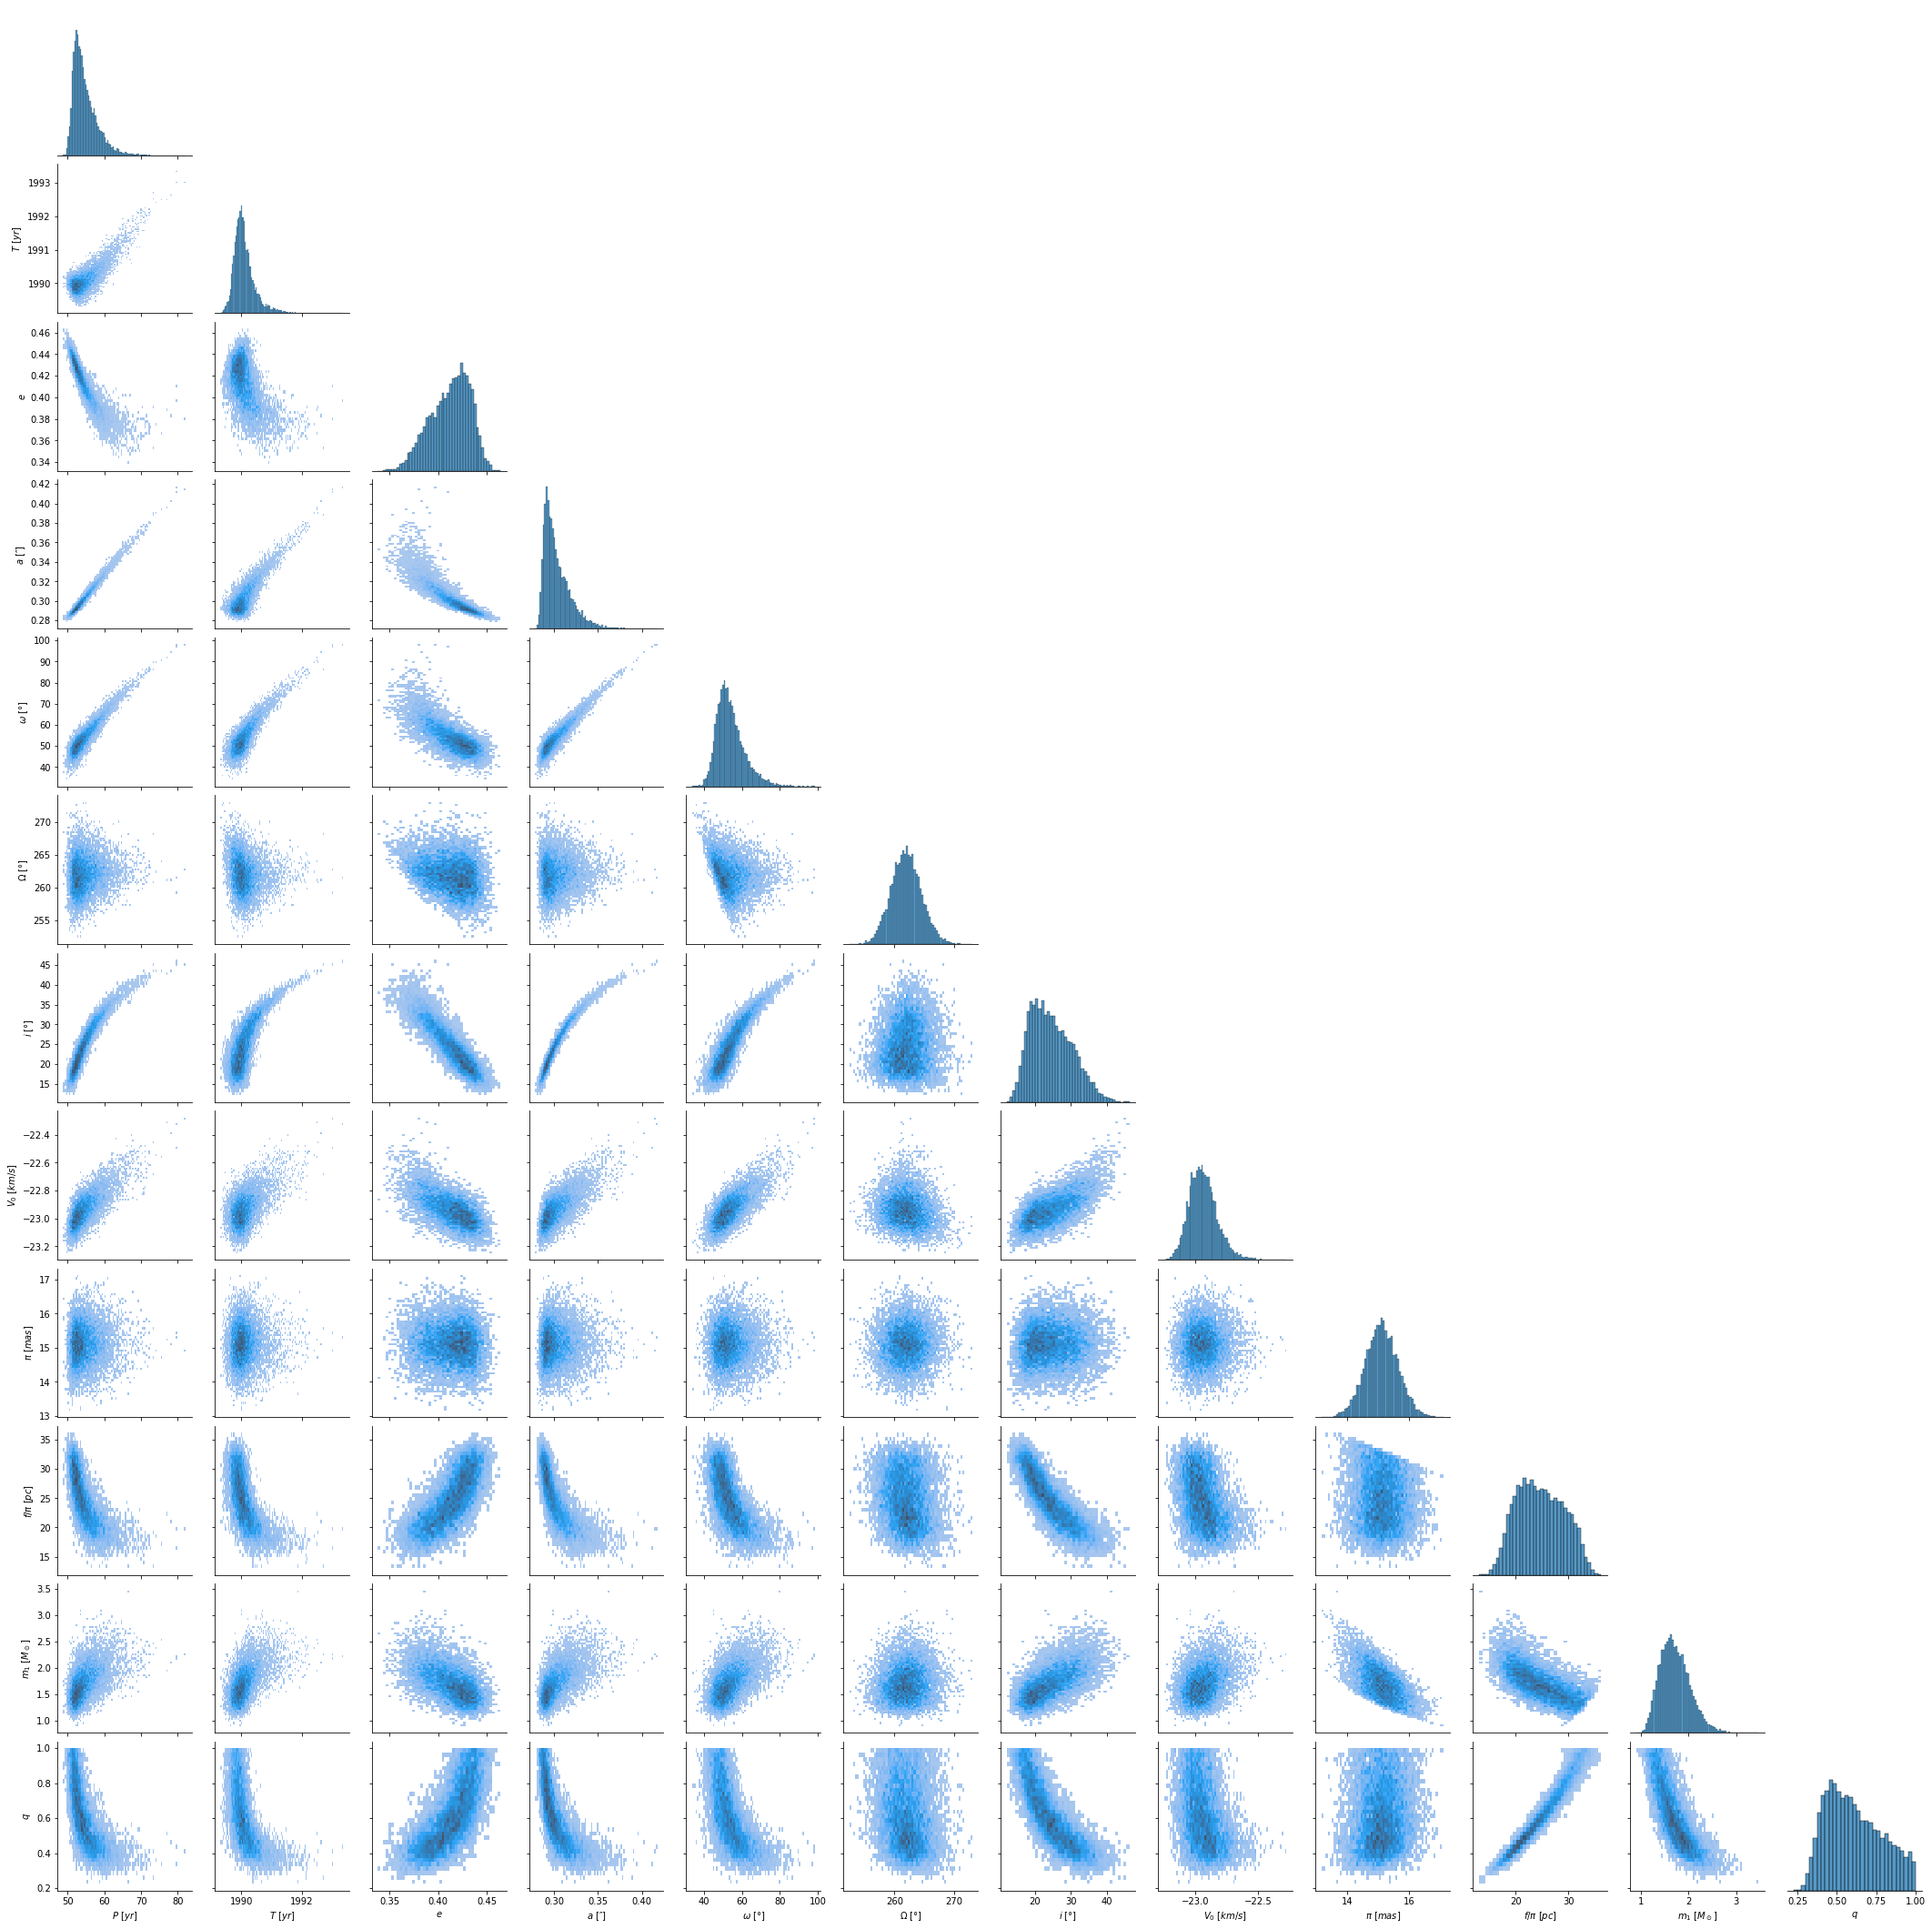

In [15]:
sns.pairplot(df.drop(columns='lp__'), kind='hist', corner=True)
plt.show()

### 4.3. Orbit & Radial Velocity Curve

In [16]:
# Aesthetics utils
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Greys_r')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

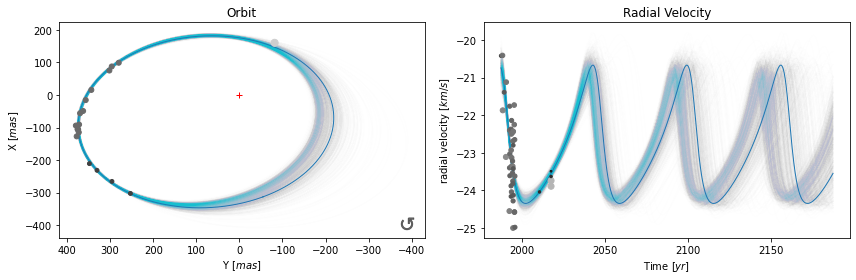

In [17]:
### Orbit & RV
plt.figure(figsize=(12,4))
rnd_idx = np.random.choice(samples.shape[0], 1000, replace=False)

### Orbit plot
plt.subplot(1, 2, 1)
# Orbit samples
for j in tqdm(range(1000)):
    P, T, e, a, w, Omega, i, V0, plx, f_plx, m1, q = samples[rnd_idx[j]]
    t = np.linspace(0, P, 1000)
    X, Y = getOrbit(t, T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
    plt.plot(Y * 1000, X * 1000, color='tab:cyan', alpha=0.005)
# MAP orbit
P, T, e, a, w, Omega, i, V0, plx, f_plx, m1, q = map_sample
t = np.linspace(0, P, 1000)
X, Y = getOrbit(t, T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
# Data projection on the MAP orbit
Xorb, Yorb = getOrbit(df_as.epoch.to_numpy(), T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
plt.plot(Y * 1000, X * 1000, color='tab:blue', linewidth=1, zorder=j)
for k in range(len(df_as)):
    plt.plot([df_as.Y[k]  * 1000, Yorb[k] * 1000], [df_as.X[k] * 1000, Xorb[k] * 1000], '--', color='blue', linewidth=0.5)
# Dataset
plt.scatter(df_as.Y * 1000, df_as.X * 1000, s=df_as.X_err * 5000, c=df_as.X_err, cmap=truncate_colormap(cmap, 0.2, 0.7), zorder=2000)
plt.plot([0], [0], '+', color='r')
legend = plt.gca().get_legend()
plt.xlabel(r'Y $[mas]$')
plt.ylabel(r'X $[mas]$')
plt.title('Orbit')
plt.gca().invert_xaxis()
# Orientation symbol: marker={r'$\circlearrowleft$', r'$\circlearrowright$'}
plt.plot([0.9 * plt.xlim()[1]],[0.9 * plt.ylim()[0]], marker=r'$\circlearrowleft$',ms=15, mew=0.5, color='black', alpha=0.6)

### RV plot
plt.subplot(1, 2, 2)
t = np.linspace(df_v1.epoch.min(), df_v1.epoch.max() + 3*P, 1000)
# RV samples
for j in tqdm(range(1000)):
    P, T, e, a, w, Omega, i, V0, plx, f_plx, m1, q = samples[rnd_idx[j]]
    V1 = getRVSingle(t, T, P, e, a, np.deg2rad(w), np.deg2rad(i), V0, f_plx)
    plt.plot(t, V1, color='tab:cyan', alpha=0.005)
# MAP RV
P, T, e, a, w, Omega, i, V0, plx, f_plx, m1, q = map_sample
V1 = getRVSingle(t, T, P, e, a, np.deg2rad(w), np.deg2rad(i), V0, f_plx)
plt.plot(t, V1, linewidth=1, color='tab:blue')    
plt.scatter(df_v1.epoch, df_v1.RV, s=df_v1.err * 30, c=df_v1.err, cmap=truncate_colormap(cmap, 0.1, 0.6), zorder=2000)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('radial velocity [$km/s$]')
plt.xlabel('Time $[yr]$')
plt.title('Radial Velocity')

plt.tight_layout()
plt.show()